In [25]:
import os

from google.colab import drive
drive.mount('/content/gdrive')

os.chdir('/content/gdrive/MyDrive/first_try_of_fastai')

print("------------------------------------------------------------------")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
------------------------------------------------------------------


In [26]:
#export
import os
os.chdir('/content/gdrive/MyDrive/first_try_of_fastai/exp')
from nb_04 import *
os.chdir('/content/gdrive/MyDrive/first_try_of_fastai')

**Initial Setup**

In [27]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh,bs = 50, 512
c=y_train.max().item()+1
loss_func = F.cross_entropy

In [28]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [29]:
#export
def create_learner(model_func, loss_func, data):
  return Learner(*model_func(data), loss_func, data)

In [30]:
learn = create_learner(get_model,loss_func, data)
run = Runner(AvgStatsCallback([accuracy]))

run.fit(3, learn)

train: [0.6716690625, tensor(0.8041)]
valid: [0.3071322998046875, tensor(0.9116)]
train: [0.2936875390625, tensor(0.9143)]
valid: [0.2397883544921875, tensor(0.9326)]
train: [0.23883791015625, tensor(0.9303)]
valid: [0.2164036376953125, tensor(0.9405)]


In [31]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)


train: [0.783822734375, tensor(0.7944)]
valid: [0.3581841796875, tensor(0.9010)]
train: [0.3490929296875, tensor(0.8994)]
valid: [0.3005599609375, tensor(0.9148)]
train: [0.29545732421875, tensor(0.9148)]
valid: [0.2629509033203125, tensor(0.9235)]


In [32]:
#export
def get_model_func(lr=0.5): return partial(get_model, lr = lr)

In [109]:
#export

class Recorder(Callback):
  def begin_fit(self): self.lrs, self.losses = [],[]

  def after_batch(self):
    if not self.in_train: return
    self.lrs.append(self.opt.param_groups[-1]['lr'])
    self.losses.append(self.loss.detach().cpu())

  def plot_lr(self): plt.plot(self.lrs)
  def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
  _order = 1
  def __init__(self, pname, sched_func): 
    self.pname, self.sched_func = pname, sched_func

  def set_param(self):
    for pg in self.opt.param_groups:
      pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)

  def begin_batch(self):
    if self.in_train: self.set_param()


In [110]:
#set_trace

In [111]:
def sched_lin(start, end):
  def _inner(start, end, pos): return start + pos*(end-start)
  return partial(_inner, start, end)

In [112]:
f = sched_lin(1,2)
f(0.3)

1.3

In [113]:
#export

def annealer(f):
  def _inner(start, end): return partial(f, start, end)
  return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [114]:
f = sched_lin(1,2)
f(0.4)

1.4

In [115]:
#sched_lin()

In [116]:
#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end - start) / 2
@annealer
def sched_no(start, end, pos): return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

In [117]:
torch.Tensor.ndim = property(lambda x: len(x.shape))

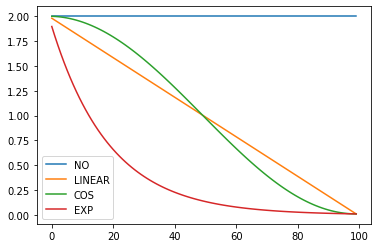

In [118]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0,100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend()

In [119]:
#export
def combine_scheds(pcts, scheds):
  assert sum(pcts) == 1.
  pcts = tensor([0] + listify(pcts))
  assert torch.all(pcts>=0)
  pcts = torch.cumsum(pcts, 0)
  def _inner(pos):
    if pos == 1:
      pass
    else:
      idx = (pos >= pcts).nonzero().max()
      actual_pos = (pos-pcts[idx]) / (pcts[idx+1] - pcts[idx])
      return scheds[idx](actual_pos)
  return _inner
  #added the if statement to get the code working for now, still dont understand why it breaks

In [120]:
sched = combine_scheds( [0.3,0.7], [sched_cos(0.3,0.6), sched_cos(0.6,0.2)] )

In [121]:
sched(1)

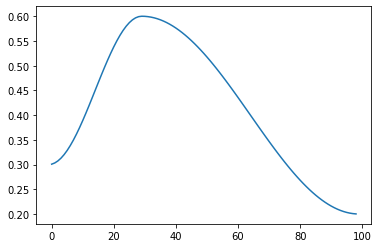

In [122]:
plt.plot(a, [sched(o) for o in p])

In [123]:
#use the following to debug code
#%debug to debug
#set_trace to trace

In [124]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler,"lr", sched)]

In [125]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [126]:
run.fit(3,learn)

train: [0.78483390625, tensor(0.7806)]
valid: [0.329712548828125, tensor(0.9062)]
train: [0.305329609375, tensor(0.9102)]
valid: [0.23794208984375, tensor(0.9315)]
train: [0.2415613671875, tensor(0.9303)]
valid: [0.2132251953125, tensor(0.9421)]


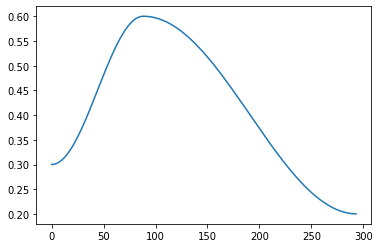

In [127]:
run.recorder.plot_lr()

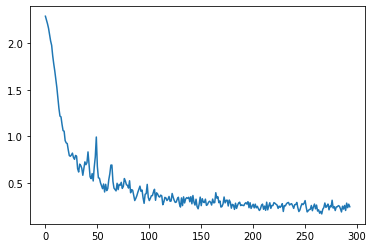

In [128]:
run.recorder.plot_loss()

In [129]:
!pip install fire

In [130]:
!python notebook2script.py 05_anneal.ipynb
print("Do__ne")

Converted 05_anneal.ipynb to exp/nb_05.py
Do__ne
